# Experimentos y análisis


In [9]:
from matplotlib import pyplot as plt
import pandas as pd
import subprocess
import os

CPU_EXEC = "../build/src/MyProjectCPU"
CL_EXEC = "../build/src/cl/MyProjectCL"
CUDA_EXEC = "../build/src/cuda/MyProjectCUDA"

## Experimento 1
Número de células evaluadas por segundo para varios tamaños de grilla $N \times M$

Variar el tamaño de la grilla con `block/local size` fijos, iteraciones fijas y sin usar `ifs`. `grid/global size` se calculan en el programa.

- Párametros:
    - Tamaño de grilla $N\times M$: Grillas cuadradas de tamaño $2^{10}$ a $2^{28}$ (incrementos de 2). De esta manera se usa de $2*1$ KB hasta $2*2^{8}$ MB de memoria ($0.5$ GB) (Se multiplica por 2 porque se necesitan tener 2 copias del mundo en memoria)

In [18]:
current_path = os.getcwd()
block = 32
iterations = 100
n_tests = 10

for i in range(4, 11+1):
    N = 2**i
    M = 2**i
    print("Running for size", N*M)
    # do 10 runs for each size
    for _ in range(n_tests):
        # CPU:                      <world width>   <world height>  <iterations>        <output_file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CPU_EXEC,   str(N),         str(M),         str(iterations),    current_path + "/cpu.csv",  str(0),         str(0)], stdout=subprocess.DEVNULL)
        # CUDA/CL:                  <world width>   <world height>  <block size>    <iterations>        <output file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CL_EXEC,    str(N),         str(M),         str(block),     str(iterations),    current_path + "/cl.csv",   str(0),         str(0)], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC,  str(N),         str(M),         str(block),     str(iterations),    current_path + "/cuda.csv", str(0),         str(0)], stdout=subprocess.DEVNULL)

KeyboardInterrupt: 

### Análisis

In [72]:
# read from csv and add correct columns
cpu = pd.read_csv("cpu.csv", header=None)
cl = pd.read_csv("cl.csv", header=None)
cuda = pd.read_csv("cuda.csv", header=None)

cpu.columns = ["width", "height", "iterations", "data creation time", "execution time", "total time"]
cpu["size"] = cpu["width"] * cpu["height"]
cpu.drop(columns=["width", "height"], inplace=True)

cl.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]
cuda.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]

print("CPU")
print(cpu)
print("CL")
print(cl)
print("CUDA")
print(cuda)

CPU
    iterations  data creation time  execution time  total time     size
0          100                  17            3620        3637     1024
1          100                  16            2766        2782     1024
2          100                  20            3329        3349     1024
3          100                  16            3288        3304     1024
4          100                  16            2732        2748     1024
..         ...                 ...             ...         ...      ...
65         100               71092        11638797    11709889  4194304
66         100               70525        11414481    11485006  4194304
67         100               68319        11391441    11459760  4194304
68         100               71698        11432931    11504629  4194304
69         100               71924        11447235    11519159  4194304

[70 rows x 5 columns]
CL
       size  block size  if use  iterations  data creation time  \
0      1024          32       0        

#### Tiempo total

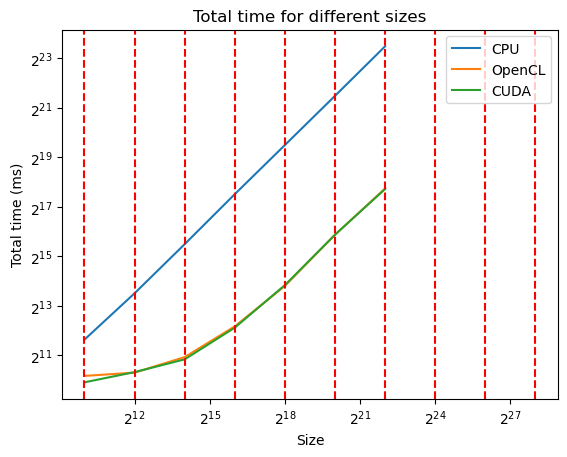

In [73]:
# plot avg total time for each size
cpu_avg = cpu.groupby("size").mean()
cl_avg = cl.groupby("size").mean()
cuda_avg = cuda.groupby("size").mean()

fig, ax = plt.subplots()
ax.plot(cpu_avg.index, cpu_avg["total time"], label="CPU")
ax.plot(cl_avg.index, cl_avg["total time"], label="OpenCL")
ax.plot(cuda_avg.index, cuda_avg["total time"], label="CUDA")
# plot vertical isolines of power of 2
for i in range(10, 29, 2):
    ax.axvline(x=2**i, color='r', linestyle='--')

ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)
ax.set_xlabel("Size")
ax.set_ylabel("Total time (ms)")
ax.legend()
plt.title("Total time for different sizes")
plt.show()
# save figure as svg
fig.savefig("total_time.svg")


#### Tiempo de ejecución

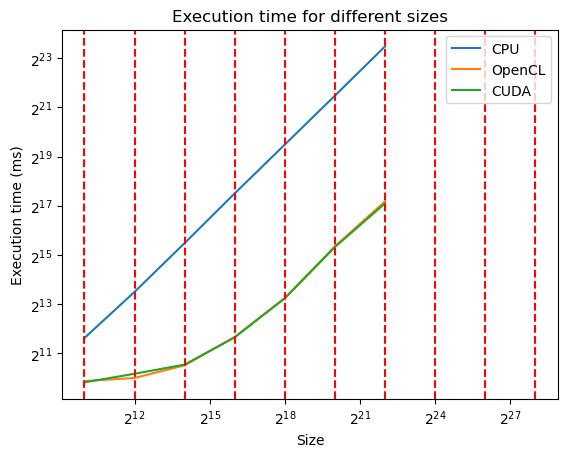

In [74]:
# plot avg execution time for each size
fig, ax = plt.subplots()
ax.plot(cpu_avg.index, cpu_avg["execution time"], label="CPU")
ax.plot(cl_avg.index, cl_avg["execution time"], label="OpenCL")
ax.plot(cuda_avg.index, cuda_avg["execution time"], label="CUDA")
for i in range(10, 29, 2):
    ax.axvline(x=2**i, color='r', linestyle='--')

ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)
ax.set_xlabel("Size")
ax.set_ylabel("Execution time (ms)")
ax.legend()
plt.title("Execution time for different sizes")
plt.show()
fig.savefig("execution_time.svg")

#### Celdas evaluadas por segundo

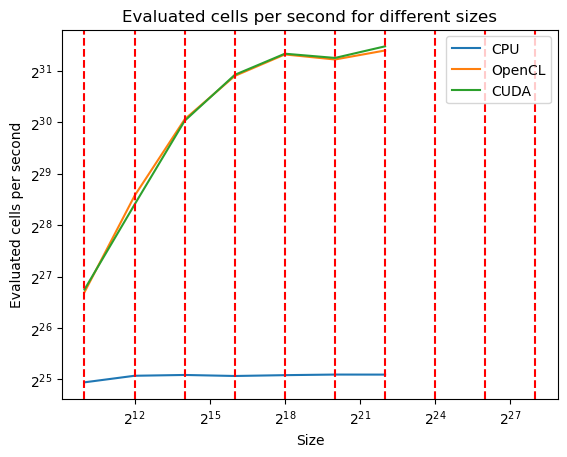

In [88]:
# plot evaluated cells per second for each size

cpu_avg["evaluated cells per second"] = cpu_avg.index*iterations / (cpu_avg["execution time"]/(10**6))
cl_avg["evaluated cells per second"] = cl_avg.index*iterations / (cl_avg["execution time"]/(10**6))
cuda_avg["evaluated cells per second"] = cuda_avg.index*iterations / (cuda_avg["execution time"]/(10**6))

fig, ax = plt.subplots()
ax.plot(cpu_avg.index, cpu_avg["evaluated cells per second"], label="CPU")
ax.plot(cl_avg.index, cl_avg["evaluated cells per second"], label="OpenCL")
ax.plot(cuda_avg.index, cuda_avg["evaluated cells per second"], label="CUDA")
for i in range(10, 29, 2):
    ax.axvline(x=2**i, color='r', linestyle='--')

ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)

ax.set_xlabel("Size")
ax.set_ylabel("Evaluated cells per second")
ax.legend()
plt.title("Evaluated cells per second for different sizes")
plt.show()
fig.savefig("evaluated_cells_per_second.svg")

#### Speedup

In [67]:
# print speedup on execution time
speedup_cl = cpu_avg["execution time"] / cl_avg["execution time"]
speedup_cuda = cpu_avg["execution time"] / cuda_avg["execution time"]

print("Speedup OpenCL")
print(speedup_cl)
print("Speedup CUDA")
print(speedup_cuda)

Speedup OpenCL
size
1024        3.367091
4096       11.304069
16384      31.324155
65536      56.966746
262144     75.233122
1048576    69.733322
4194304    78.773472
Name: execution time, dtype: float64
Speedup CUDA
size
1024        3.490481
4096       10.042196
16384      30.702652
65536      57.809559
262144     75.992270
1048576    71.204446
4194304    83.313127
Name: execution time, dtype: float64


#### Distribución de tiempos

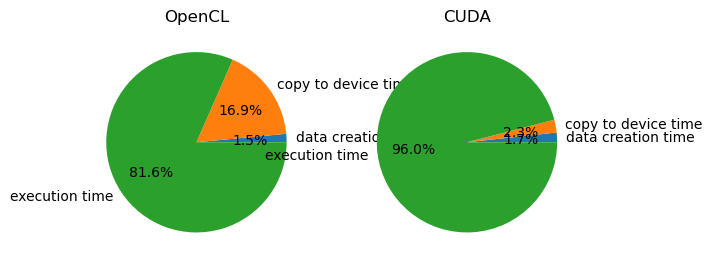

In [68]:
cl_avg["data creation time"] /= cl_avg.index
cl_avg["copy to device time"] /= cl_avg.index
cl_avg["execution time"] /= cl_avg.index
cl_avg["copy to host time"] /= cl_avg.index

cuda_avg["data creation time"] /= cuda_avg.index
cuda_avg["copy to device time"] /= cuda_avg.index
cuda_avg["execution time"] /= cuda_avg.index
cuda_avg["copy to host time"] /= cuda_avg.index

# plot a two pie chart of the average time spent on each step for OpenCL and CUDA
fig, ax = plt.subplots(1, 2)
ax[0].pie(cl_avg.iloc[0][3:6], labels=cl_avg.columns[3:6], autopct='%1.1f%%')
ax[0].set_title("OpenCL")
ax[1].pie(cuda_avg.iloc[0][3:6], labels=cuda_avg.columns[3:6], autopct='%1.1f%%')
ax[1].set_title("CUDA")
plt.show()
fig.savefig("time_spent.svg")

### Conclusión

## Experimento 2
Número de células evaluadas por segundo utilizando ifs (condicionales) para preguntar por la vecindad.  

Utilizar `ifs`, dejar fijo el tamaño de `block/local size` con tamaño de grilla variable, iteraciones fijas y sin usar `grid/global size` se calculan en el programa.

- Párametros:
    - Comparar la activación de los ifs:  
        - Activado (1)  
        - Desactivado (0)
    - Tamaño de grilla $N\times M$: Grillas cuadradas de tamaño $2^{10}$ a $2^{28}$ (incrementos de 2). De esta manera se usa de $2*1$ KB hasta $2*2^{8}$ MB de memoria ($0.5$ GB) (Se multiplica por 2 porque se necesitan tener 2 copias del mundo en memoria)

In [69]:
current_path = os.getcwd()

for i in range(5, 11+1):
    N = 2**i
    M = 2**i
    print("Running for size", N*M)
    # do 10 runs for each size
    for _ in range(n_tests):
        # CPU:                      <world width>   <world height>  <iterations>        <output_file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CPU_EXEC,   str(N),         str(M),         str(iterations),    current_path + "/cpu_if.csv",  str(0),         str(1)], stdout=subprocess.DEVNULL)
        # CUDA/CL:                  <world width>   <world height>  <block size>    <iterations>        <output file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CL_EXEC,    str(N),         str(M),         str(block),     str(iterations),    current_path + "/cl_if.csv",   str(0),         str(1)], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC,  str(N),         str(M),         str(block),     str(iterations),    current_path + "/cuda_if.csv", str(0),         str(1)], stdout=subprocess.DEVNULL)

Running for size 1024


KeyboardInterrupt: 

In [89]:
# read from csv and add correct columns
cpu_if = pd.read_csv("cpu_if.csv", header=None)
cl_if = pd.read_csv("cl_if.csv", header=None)
cuda_if = pd.read_csv("cuda_if.csv", header=None)

cpu_if.columns = ["width", "height", "iterations", "data creation time", "execution time", "total time"]
cpu_if["size"] = cpu_if["width"] * cpu_if["height"]
cpu_if.drop(columns=["width", "height"], inplace=True)

cl_if.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]
cuda_if.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]

print("CPU")
print(cpu_if)
print("CL")
print(cl_if)
print("CUDA")
print(cuda_if)

CPU
    iterations  data creation time  execution time  total time     size
0          100                  21            6773        6794     1024
1          100                  17            5792        5809     1024
2          100                  22            4868        4890     1024
3          100                  16            5449        5465     1024
4          100                  21            5789        5810     1024
..         ...                 ...             ...         ...      ...
65         100               71281        22615691    22686972  4194304
66         100               71550        22428674    22500224  4194304
67         100               70846        22431846    22502692  4194304
68         100               78195        22795959    22874154  4194304
69         100               73323        21971837    22045160  4194304

[70 rows x 5 columns]
CL
       size  block size  if use  iterations  data creation time  \
0      1024          32       1        

#### Tiempo de ejecución

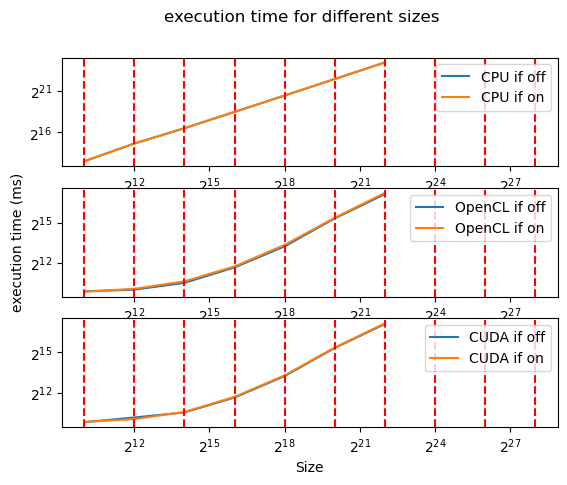

In [83]:
#Ploteamos
# Calculate average execution time by size
cpu_if_avg = cpu_if.groupby("size").mean()
cl_if_avg = cl_if.groupby("size").mean()
cuda_if_avg = cuda_if.groupby("size").mean()

# Plotting
fig, ax = plt.subplots(3)

# Plot each dataset
ax[0].plot(cpu_avg.index, cpu_if_avg["execution time"], label="CPU if off")
ax[0].plot(cpu_if_avg.index, cpu_if_avg["execution time"], label="CPU if on")

ax[1].plot(cl_avg.index, cl_avg["execution time"], label="OpenCL if off")
ax[1].plot(cl_if_avg.index, cl_if_avg["execution time"], label="OpenCL if on")

ax[2].plot(cuda_avg.index, cuda_avg["execution time"], label="CUDA if off")
ax[2].plot(cuda_if_avg.index, cuda_if_avg["execution time"], label="CUDA if on")


# Plot vertical isolines of power of 2
for i in range(10, 29, 2):
#     ax.axvline(x=2**i, color='r', linestyle='--')
    [a.axvline(x=2**i, color='r', linestyle='--') for a in ax]

# Set log scales
# ax.set_yscale('log', base=2)
[a.set_yscale('log', base=2) for a in ax]
# ax.set_xscale('log', base=2)
[a.set_xscale('log', base=2) for a in ax]

# Add labels, title, and legend
# ax.set_xlabel("Size")
ax[-1].set_xlabel("Size")
# ax.set_ylabel("execution time (ms)")
ax[1].set_ylabel("execution time (ms)")
# ax.legend()
[a.legend() for a in ax]
# plt.title("execution time for different sizes")
plt.suptitle("execution time for different sizes")

# Show plot
plt.show()
# Save figure as svg
fig.savefig("execution_time_if.svg")

#### Celdas evaluadas por segundo

In [ ]:
# plot evaluated cells per second for each size

cpu_if_avg["evaluated cells per second"] = cpu_if_avg.index*iterations / (cpu_if_avg["execution time"]/(10**6))
cl_if_avg["evaluated cells per second"] = cl_if_avg.index*iterations / (cl_if_avg["execution time"]/(10**6))
cuda_if_avg["evaluated cells per second"] = cuda_if_avg.index*iterations / (cuda_if_avg["execution time"]/(10**6))

# Plotting
fig, ax = plt.subplots(3)

# Plot each dataset
ax[0].plot(cpu_avg.index, cpu_if_avg["evaluated cells per second"], label="CPU if off")
ax[0].plot(cpu_if_avg.index, cpu_if_avg["evaluated cells per second"], label="CPU if on")

ax[1].plot(cl_avg.index, cl_avg["evaluated cells per second"], label="OpenCL if off")
ax[1].plot(cl_if_avg.index, cl_if_avg["evaluated cells per second"], label="OpenCL if on")

ax[2].plot(cuda_avg.index, cuda_avg["evaluated cells per second"], label="CUDA if off")
ax[2].plot(cuda_if_avg.index, cuda_if_avg["evaluated cells per second"], label="CUDA if on")


# Plot vertical isolines of power of 2
for i in range(10, 29, 2):
#     ax.axvline(x=2**i, color='r', linestyle='--')
    [a.axvline(x=2**i, color='r', linestyle='--') for a in ax]

# Set log scales
# ax.set_yscale('log', base=2)
[a.set_yscale('log', base=2) for a in ax]
# ax.set_xscale('log', base=2)
[a.set_xscale('log', base=2) for a in ax]

ax.set_xlabel("Size")
ax.set_ylabel("Evaluated cells per second")
ax.legend()
plt.title("Evaluated cells per second for different sizes")
plt.show()
fig.savefig("evaluated_cells_per_second.svg")

## Experimento 3
Número de células evaluadas por segundo para varios tamaños de bloque

Variar el tamaño de `block/local size` con tamaño de grilla fijo $2^{20}$, iteraciones fijas y sin usar `ifs`. `grid/global size` se calculan en el programa.

- Párametros:
    - Tamaño de bloque:
    
        - Primero usando 6 múltiplos de 32:     32, 64, 128, 256, 512, 1024
    
        - Luego usando 6 no múltiplos de 32:  24, 48, 96, 192, 384, 768

In [24]:
current_path = os.getcwd()
N = 2**10
M = 2**10

for i in range(0, 6):
    block = 2**i * 32
    print("Running for block size", block)
    # do 10 runs for each size
    for _ in range(n_tests):
        # CUDA/CL:                  <world width>   <world height>  <block size>    <iterations>        <output file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CL_EXEC,    str(N),         str(M),         str(block),     str(iterations),    current_path + "/cl_block.csv",   str(0),         str(0)], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC,  str(N),         str(M),         str(block),     str(iterations),    current_path + "/cuda_block.csv", str(0),         str(0)], stdout=subprocess.DEVNULL)

for i in range(0, 6):
    block = 2**i * 24
    print("Running for block size", block)
    # do 10 runs for each size
    for _ in range(n_tests):
        # CUDA/CL:                  <world width>   <world height>  <block size>    <iterations>        <output file>               <0|1 (debug)>   <0|1 (if)>
        subprocess.run([CL_EXEC,    str(N),         str(M),         str(block),     str(iterations),    current_path + "/cl_block.csv",   str(0),         str(0)], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC,  str(N),         str(M),         str(block),     str(iterations),    current_path + "/cuda_block.csv", str(0),         str(0)], stdout=subprocess.DEVNULL)



Running for block size 32
Running for block size 64
Running for block size 128
Running for block size 256
Running for block size 512
Running for block size 1024
Running for block size 24
Running for block size 48
Running for block size 96
Running for block size 192
Running for block size 384
Running for block size 768


In [25]:
# read from csv and add correct columns
cl_block = pd.read_csv("cl_block.csv", header=None)
cuda_block = pd.read_csv("cuda_block.csv", header=None)

cl_block.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]
cuda_block.columns = ["size", "block size", "if use", "iterations", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]

print("CL_block")
print(cl_block)
print("CUDA_block")
print(cuda_block)

CPU_block
     iterations  data creation time  execution time  total time     size
0           100               18584         2897715     2916299  1048576
1           100               17438         3014817     3032255  1048576
2           100               19679         2914654     2934333  1048576
3           100               17263         2909456     2926719  1048576
4           100               17153         2924396     2941549  1048576
..          ...                 ...             ...         ...      ...
115         100               17519         2961706     2979225  1048576
116         100               18652         2903229     2921881  1048576
117         100               17760         2866631     2884391  1048576
118         100               18088         2911721     2929809  1048576
119         100               17715         3009552     3027267  1048576

[120 rows x 5 columns]
CL_block
        size  block size  if use  iterations  data creation time  \
0    1048576 

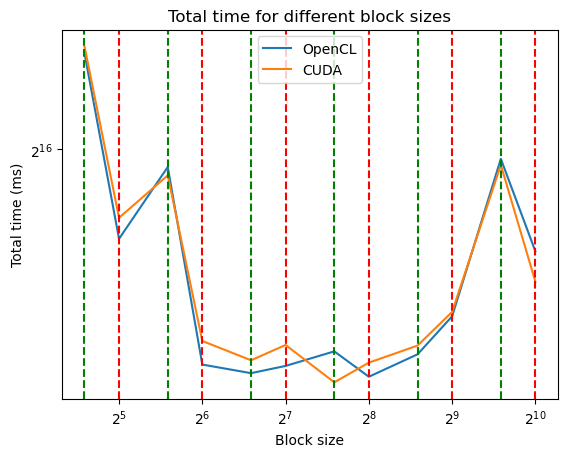

In [34]:
# plot avg total time for each block size
cl_block_avg = cl_block.groupby("block size").mean()
cuda_block_avg = cuda_block.groupby("block size").mean()

fig, ax = plt.subplots()
ax.plot(cl_block_avg.index, cl_block_avg["total time"], label="OpenCL")
ax.plot(cuda_block_avg.index, cuda_block_avg["total time"], label="CUDA")

# plot vertical isolines of power of 2 multiples of 32 and 24
for i in range(0, 6):
    ax.axvline(x=2**i * 32, color='r', linestyle='--')
    ax.axvline(x=2**i * 24, color='g', linestyle='--')

ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)
ax.set_xlabel("Block size")
ax.set_ylabel("Total time (ms)")
ax.legend()
plt.title("Total time for different block sizes")
plt.show()
# save figure as svg
fig.savefig("total_time_block.svg")

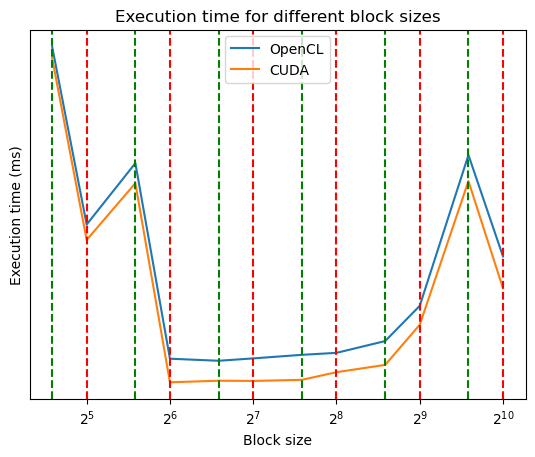

In [35]:
# plot avg execution time for each block size
fig, ax = plt.subplots()
ax.plot(cl_block_avg.index, cl_block_avg["execution time"], label="OpenCL")
ax.plot(cuda_block_avg.index, cuda_block_avg["execution time"], label="CUDA")

# plot vertical isolines of power of 2 multiples of 32 and 24
for i in range(0, 6):
    ax.axvline(x=2**i * 32, color='r', linestyle='--')
    ax.axvline(x=2**i * 24, color='g', linestyle='--')

ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)
ax.set_xlabel("Block size")
ax.set_ylabel("Execution time (ms)")
ax.legend()
plt.title("Execution time for different block sizes")
plt.show()
# save figure as svg
fig.savefig("execution_time_block.svg")

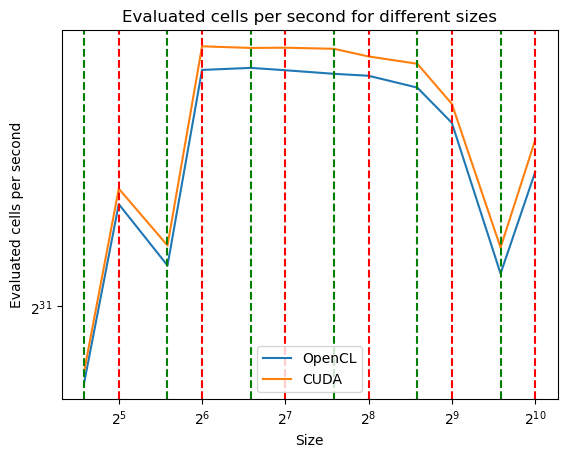

In [39]:
# plot evaluated cells per second for each block size

cl_block_avg["evaluated cells per second"] = cl_block_avg["size"]*iterations / (cl_block_avg["execution time"]/(10**6))
cuda_block_avg["evaluated cells per second"] = cuda_block_avg["size"]*iterations / (cuda_block_avg["execution time"]/(10**6))

fig, ax = plt.subplots()
ax.plot(cl_block_avg.index, cl_block_avg["evaluated cells per second"], label="OpenCL")
ax.plot(cuda_block_avg.index, cuda_block_avg["evaluated cells per second"], label="CUDA")

# plot vertical isolines of power of 2 multiples of 32 and 24
for i in range(0, 6):
    ax.axvline(x=2**i * 32, color='r', linestyle='--')
    ax.axvline(x=2**i * 24, color='g', linestyle='--')

ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)
ax.set_xlabel("Size")
ax.set_ylabel("Evaluated cells per second")
ax.legend()
plt.title("Evaluated cells per second for different sizes")
plt.show()
fig.savefig("evaluated_cells_per_second_block.svg")